# Data cleaning

Goal : develop an application to suggest a better product according to the nutrition grade.

We will focus on product sold in France.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer

Utils

In [2]:
def nb_col_rows(df):
    N = len(df)
    variables = df.columns
    nb_variables = len(variables)
    print(f'N: {N}', f'Number of variables: {nb_variables}', sep='\t')
    return N, nb_variables

def missing_percentage(df, variable):
    return len(df[df[variable].isna()])/len(df)

def completion(df, variable):
    res = missing_percentage(df, variable)
    print(f'Completion of variable \'{variable}\': {round((1-res)*100, 2)}%')

def missing_values(df):
    nb_na = df.isnull().sum()
    return nb_na[nb_na>0]

In [3]:
df = pd.read_csv('data/products.csv', sep='\t')

/tmp/ipykernel_7528/3047720778.py:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/products.csv', sep='\t')


## First sight

In [4]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
nb_col_rows(df)

N: 320772	Number of variables: 162


(320772, 162)

In [6]:
variables = df.columns
list(variables)

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_fr',
 'ingredients_text',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'serving_size',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutritio

## Pre-preprocessing

### Variable selection

Keeping only products sold in France

In [7]:
res = completion(df, 'countries_fr')

Completion of variable 'countries_fr': 99.91%


In [8]:
df_fr = df[df['countries_fr'].fillna('').str.contains('France')]
nb_col_rows(df_fr)

N: 98440	Number of variables: 162


(98440, 162)

Target variable : 'nutrition_grade_df'

In [9]:
print(f'Target variable: \'nutrition_grade_fr\'')
res = completion(df, 'nutrition_grade_fr')

Target variable: 'nutrition_grade_fr'
Completion of variable 'nutrition_grade_fr': 68.96%


In [10]:
df_fr = df_fr[~df_fr['nutrition_grade_fr'].isna()]
df_fr = df_fr[~df_fr['code'].isna()]
nb_col_rows(df_fr)

N: 61415	Number of variables: 162


(61415, 162)

Keeping relevant and complete variables (up to 70%)

In [11]:
for variable in variables:
    completion(df_fr, variable)

Completion of variable 'code': 100.0%
Completion of variable 'url': 100.0%
Completion of variable 'creator': 100.0%
Completion of variable 'created_t': 100.0%
Completion of variable 'created_datetime': 100.0%
Completion of variable 'last_modified_t': 100.0%
Completion of variable 'last_modified_datetime': 100.0%
Completion of variable 'product_name': 99.44%
Completion of variable 'generic_name': 48.3%
Completion of variable 'quantity': 74.24%
Completion of variable 'packaging': 68.39%
Completion of variable 'packaging_tags': 68.39%
Completion of variable 'brands': 99.44%
Completion of variable 'brands_tags': 99.44%
Completion of variable 'categories': 72.45%
Completion of variable 'categories_tags': 72.45%
Completion of variable 'categories_fr': 72.45%
Completion of variable 'origins': 16.61%
Completion of variable 'origins_tags': 16.6%
Completion of variable 'manufacturing_places': 32.29%
Completion of variable 'manufacturing_places_tags': 32.29%
Completion of variable 'labels': 44.69

In [12]:
keep_var = [
    'code',
    'product_name',
    'brands',
    'nutrition_grade_fr',
    'pnns_groups_1',
    'pnns_groups_2',
    'packaging',
    'ingredients_text',
    'additives',
    'ingredients_from_palm_oil_n'
]

for variable in df.columns:
    if '100g' in variable and missing_percentage(df_fr, variable)<0.30:
        keep_var.append(variable)
keep_var.remove('nutrition-score-uk_100g')
print(f'Number of relevant variables: {len(keep_var)}')

Number of relevant variables: 20


In [13]:
keep_var

['code',
 'product_name',
 'brands',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'packaging',
 'ingredients_text',
 'additives',
 'ingredients_from_palm_oil_n',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition-score-fr_100g']

Droping duplicates

In [14]:
df_relevant_with_dupl = df_fr[keep_var]
print('Before droping duplicates :')
N1, x = nb_col_rows(df_relevant_with_dupl)

Before droping duplicates :
N: 61415	Number of variables: 20


In [15]:

print('After droping duplicates :')
df_relevant=df_relevant_with_dupl.drop_duplicates(subset=['code'])
df_relevant=df_relevant.drop_duplicates(subset=['product_name', 'brands'])
df_relevant.reset_index(drop=True, inplace=True)
N2, x = nb_col_rows(df_relevant)
print(f"Number of duplicates deleted: {N1-N2}")

After droping duplicates :
N: 59198	Number of variables: 20
Number of duplicates deleted: 2217


Converting 'energy_100g' from J to kCal

In [16]:
df_relevant["energy_100g"] = df_relevant["energy_100g"]/4.184

### Missing values

In [17]:
missing_values(df_relevant)

product_name                     155
brands                           210
pnns_groups_1                  13922
pnns_groups_2                  13831
packaging                      18831
ingredients_text               19778
additives                      19786
ingredients_from_palm_oil_n    19778
energy_100g                       77
fat_100g                       16812
saturated-fat_100g                77
carbohydrates_100g             16866
sugars_100g                       77
fiber_100g                     15863
proteins_100g                     77
salt_100g                         77
sodium_100g                       77
dtype: int64

In [18]:
df_final = df_relevant.copy()

#### Qualitative variables

Replacing missing values by ''

In [19]:
for key in ['product_name', 'brands', 'pnns_groups_1', 'pnns_groups_2', 'packaging', 'ingredients_text', 'additives']:
    df_final.fillna({key: ''}, inplace=True)
df_final.replace('unknown', '')
missing_values(df_final)

ingredients_from_palm_oil_n    19778
energy_100g                       77
fat_100g                       16812
saturated-fat_100g                77
carbohydrates_100g             16866
sugars_100g                       77
fiber_100g                     15863
proteins_100g                     77
salt_100g                         77
sodium_100g                       77
dtype: int64

In [20]:
missing_values(df_final)

ingredients_from_palm_oil_n    19778
energy_100g                       77
fat_100g                       16812
saturated-fat_100g                77
carbohydrates_100g             16866
sugars_100g                       77
fiber_100g                     15863
proteins_100g                     77
salt_100g                         77
sodium_100g                       77
dtype: int64

#### Palm Oil

In [21]:
df_final['ingredients_from_palm_oil_n'].value_counts()

ingredients_from_palm_oil_n
0.0    36346
1.0     3032
2.0       42
Name: count, dtype: int64

Identifying '0' to 'no ingredients from palm oil' ; '1' and '2' to 'ingredients from palm oil'

In [22]:
# 'palm' not in df_final['additives'] nor 'palm' in df_final['ingredients_text']
mask = (~df_final['additives'].str.contains('palm') & ~df_final['ingredients_text'].str.contains('palm'))

df_final.loc[mask, 'ingredients_from_palm_oil_n'].value_counts()

ingredients_from_palm_oil_n
0.0    36024
1.0       30
Name: count, dtype: int64

In [23]:
# 'palm' in df_final['additives'] or 'palm' in df_final['ingredients_text']
mask = (df_final['additives'].str.contains('palm') | df_final['ingredients_text'].str.contains('palm'))

df_final.loc[mask, 'ingredients_from_palm_oil_n'].value_counts()

ingredients_from_palm_oil_n
1.0    3002
0.0     322
2.0      42
Name: count, dtype: int64

In [24]:
# For missing values : number of rows where :
# 'palm' in df_final['additives'] or 'palm' in df_final['ingredients_text'] 

len(df_final[(df_final['ingredients_from_palm_oil_n'].isnull()) & (df_final['additives'].str.contains('palm') | df_final['ingredients_text'].str.contains('palm'))])

0

Creating a new variable 'palm_oil' : '0' if palm oil not in product ; '1' if palm oil in product

In [25]:
# replace 2 by 1
df_final['ingredients_from_palm_oil_n']=df_final['ingredients_from_palm_oil_n'].replace(2,1)

# replace 0 by 1 if 'palm' in df_final['additives'] or 'palm' in df_final['ingredients_text'] 
mask = (df_final['ingredients_from_palm_oil_n'] == 0) & (df_final['additives'].str.contains('palm') | df_final['ingredients_text'].str.contains('palm'))
df_final['ingredients_from_palm_oil_n']=df_final.loc[mask,'ingredients_from_palm_oil_n'].replace(0,1)

# replace missing values with 0
df_final['ingredients_from_palm_oil_n'].fillna(0, inplace=True)

/tmp/ipykernel_7528/923714440.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['ingredients_from_palm_oil_n'].fillna(0, inplace=True)


In [26]:
df_final['ingredients_from_palm_oil_n'].value_counts()

ingredients_from_palm_oil_n
0.0    58876
1.0      322
Name: count, dtype: int64

In [27]:
df_final.rename(columns={'ingredients_from_palm_oil_n': 'palm_oil'})

,code,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,packaging,ingredients_text,additives,palm_oil,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
0,36252,Lion Peanut x2,Sunridge,e,unknown,unknown,,"Milk chocolate coating (evaporated cane juice,...",[ milk-chocolate-coating -> en:milk-chocolate...,0.0,450.047801,20.0,12.50,70.0,57.50,2.5,2.50,0.09652,0.038000,22.0
1,10187319,Mini Confettis,Alice Délice,d,,,,,,0.0,418.977055,NaN,0.80,NaN,87.70,0.9,0.60,0.01000,0.003937,14.0
2,10207260,Praliné Amande Et Noisette,Alice Délice,d,,,,,,0.0,575.047801,NaN,2.90,NaN,50.30,3.9,9.50,0.00300,0.001181,14.0
3,40608754,"Pepsi, Nouveau goût !",Pepsi,e,Beverages,Sweetened beverages,Canette aluminium,"Eau gazéifiée, sucre, colorant caramel E150d, ...",[ eau-gazeifiee -> fr:eau-gazeifiee ] [ eau...,0.0,42.304015,0.0,0.00,10.4,10.40,0.0,0.00,0.02540,0.010000,13.0
4,69161025,Tarte Poireaux Et Lardons,Bo Frost,d,,,,,,0.0,257.887189,NaN,11.00,NaN,1.00,1.4,7.50,0.80000,0.314961,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59193,9782211109758,Verrine Cheescake Myrtille,Kayser,d,,,,,,0.0,259.082218,NaN,12.00,NaN,10.50,0.0,8.70,0.29000,0.114173,16.0
59194,9782401029101,Fiche Brevet,Hatier,b,,,,,,0.0,0.956023,NaN,1.00,NaN,1.00,10.0,10.00,10.00000,3.937008,0.0
59195,9847548283004,Tartines craquantes bio au sarrasin,Le Pain des fleurs,a,Cereals and potatoes,Bread,"Boîte,Carton,Sachet,Plastique",,,0.0,392.686424,2.8,0.60,74.8,2.60,5.9,13.00,0.68000,0.267717,-4.0
59196,9900000000233,Amandes,Biosic,b,,,,,,0.0,575.047801,NaN,3.73,NaN,3.89,12.2,21.22,0.10000,0.039370,0.0


In [28]:
missing_values(df_final)

energy_100g              77
fat_100g              16812
saturated-fat_100g       77
carbohydrates_100g    16866
sugars_100g              77
fiber_100g            15863
proteins_100g            77
salt_100g                77
sodium_100g              77
dtype: int64

#### Fibers

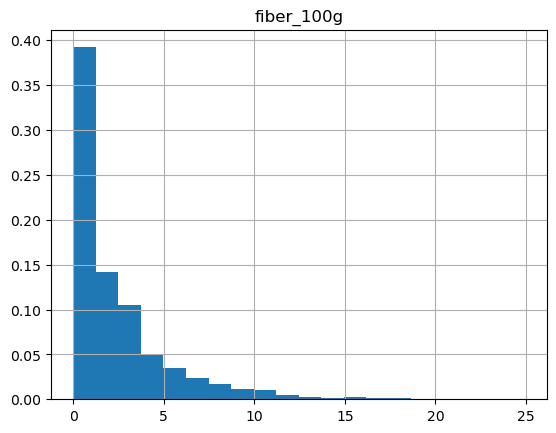

In [29]:
df_final[df_final['fiber_100g']<25]['fiber_100g'].hist(density=True, bins=20)
plt.title('fiber_100g')
plt.show()

Replacing missing values by 0

In [30]:
df_final.fillna({'fiber_100g': 0}, inplace=True)

### Protein, Sugar, Saturated fat, Salt

In [31]:
mask = df_final['proteins_100g'].isna() & df_final['sugars_100g'].isna() & df_final['saturated-fat_100g'].isna()
print(df_final.loc[mask, :].shape[0])
df_final.loc[mask, :].head()

77


,code,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,packaging,ingredients_text,additives,ingredients_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
177,24463061163,Sriracha Hot Chili Sauce,"Huy Fong foods, Huy Fong Foods Inc.",b,Fat and sauces,Dressings and sauces,plastic bottle,"Chili, Sugar, Salt, Garlic, Distilled Vinegar,...",[ chili -> en:chili ] [ sugar -> en:sugar ...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
302,41500053448,Classic Yellow,French's,b,Fat and sauces,Dressings and sauces,"Plastique,Flacon","vinaigre, eau, graines de moutarde, sel, papri...",[ vinaigre -> fr:vinaigre ] [ eau -> fr:eau...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
315,42272010516,Nouilles chinoises et légumes,Amy's kitchen,b,Composite foods,One-dish meals,,,,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
626,87703168787,Mirin,Sukina,b,,Alcoholic beverages,Bouteille,"Fructose, Glucose, Sorbitol-D, Vinaigre, Sucre...",[ fructose -> fr:fructose ] [ glucose -> fr...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
681,949453,Sparkling Scottish Mountain Water,Marks & Spencer,b,Beverages,Non-sugared beverages,"Bouteille,Plastique",eau,[ eau -> fr:eau ],0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0


Deleting rows with missing values

In [32]:
df_final.dropna(subset=['proteins_100g'], inplace=True)

In [33]:
missing_values(df_final)

fat_100g              16735
carbohydrates_100g    16789
dtype: int64

#### Carbohydrates, Fat

In [34]:
# Number of row with exactly 1 missing value

mask = (~df_final['carbohydrates_100g'].isna() & df_final['fat_100g'].isna()) | (df_final['carbohydrates_100g'].isna() & ~df_final['fat_100g'].isna())
df_final.loc[mask, :].shape[0]

224

Median of carbohydrates_100g: 15.0


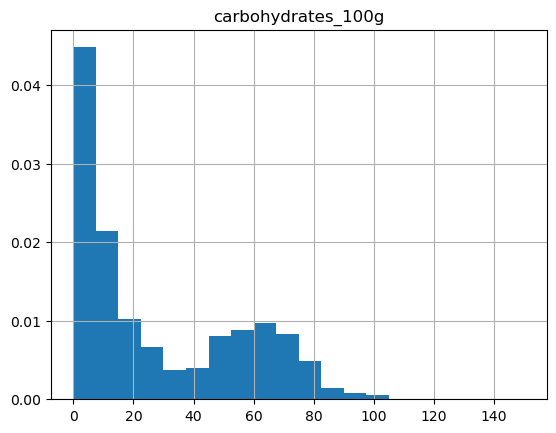

Median of fat_100g: 7.0


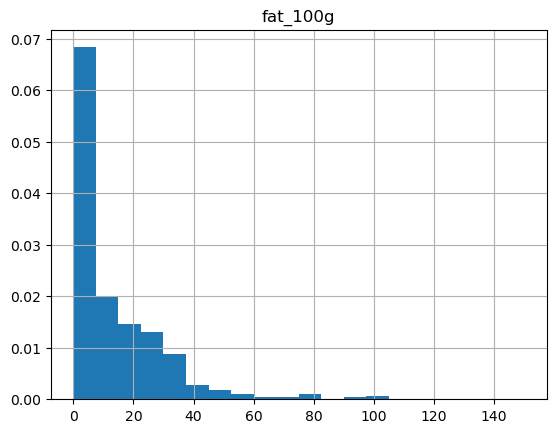

In [35]:
for var in ['carbohydrates_100g', 'fat_100g']:
    print(f'Median of {var}: {df_final[var].median()}')
    df_final[var].hist(density=True, bins=20, range=(0,150))
    plt.title(var)
    plt.show()

In [36]:
df_final.groupby(['pnns_groups_1'])[['carbohydrates_100g', 'fat_100g']].std()

,carbohydrates_100g,fat_100g
pnns_groups_1,,
,27.287103,16.439672
Beverages,19.435535,2.702240
Cereals and potatoes,21.946965,7.589650
Composite foods,10.139740,5.284835
Fat and sauces,10.188086,36.122356
Fish Meat Eggs,3.204735,11.943700
Fruits and vegetables,19.076729,8.489372
Milk and dairy products,10.032733,11.786845
Salty snacks,20.230186,16.354829


In [37]:
df_final.groupby(['pnns_groups_2'])[['carbohydrates_100g', 'fat_100g']].std()

,carbohydrates_100g,fat_100g
pnns_groups_2,,
,27.175407,17.453212
Alcoholic beverages,5.705972,2.797812
Appetizers,15.139185,13.643736
Artificially sweetened beverages,15.823705,0.291835
Biscuits and cakes,10.473087,7.372498
Bread,13.198456,6.144182
Breakfast cereals,9.515719,6.481570
Cereals,22.326693,6.537892
Cheese,3.025530,8.963325


Replacing missing values with median of 'pnns_groups_2'

In [38]:
pnns_2_med_df = df_final.groupby(['pnns_groups_2'])[[
    'carbohydrates_100g',
    'fat_100g', 'energy_100g',
    'saturated-fat_100g',
    'sugars_100g',
    'fiber_100g',
    'proteins_100g',
    'salt_100g',
    'sodium_100g',
    'nutrition-score-fr_100g'
]].median()

In [39]:
# Reset index of pnns_2_med_df to ensure 'pnns_groups_2' is a column
pnns_2_med_df.reset_index(inplace=True)

# Merge based on "pnns_groups_2" to fill missing values
filled_df = pd.merge(df_final, pnns_2_med_df[['pnns_groups_2',
                    'energy_100g',
                    'fat_100g',
                    'saturated-fat_100g',
                    'carbohydrates_100g',
                    'sugars_100g',
                    'fiber_100g',
                    'proteins_100g',
                    'salt_100g',
                    'sodium_100g',
                    'nutrition-score-fr_100g']], 
                     how='left', on='pnns_groups_2', suffixes=('', '_pnns'))

# Update missing values in df_final
df_final['carbohydrates_100g'] = df_final['carbohydrates_100g'].fillna(filled_df['carbohydrates_100g_pnns'])
df_final['fat_100g'] = df_final['fat_100g'].fillna(filled_df['fat_100g_pnns'])


In [40]:
missing_values(df_final)

fat_100g              38
carbohydrates_100g    38
dtype: int64

In [41]:
quant_columns = [
    "energy_100g",
    "fat_100g",
    "saturated-fat_100g",
    "carbohydrates_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g"
]

def knn_imputer(n):
    imputer = KNNImputer(n_neighbors=n)
    copy_df = df_final.copy().reset_index()
    copy_df[quant_columns] = imputer.fit_transform(copy_df[quant_columns])

    plt.figure(figsize=(12, 8))
    y=1
    for i, var in enumerate(quant_columns, start=1):
        imputed_indices = np.where(np.isnan(df_final[var]))[0]
        copy_df_imputed = copy_df.iloc[imputed_indices]
        copy_df_imputed.drop(columns=['index'], inplace=True)
        if imputed_indices.shape[0]>0:
            plt.subplot(2, 4, y)
            copy_df_imputed[var].plot(kind='hist', bins=30, alpha=0.5, color='orange')
            plt.title(f'Imputed Data (n={n}): {var}')
            y+=1
    plt.tight_layout()
    plt.show()

    return copy_df

/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/26151

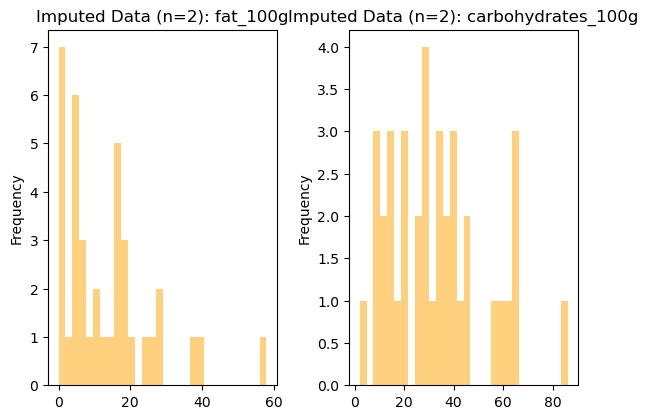

/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/26151

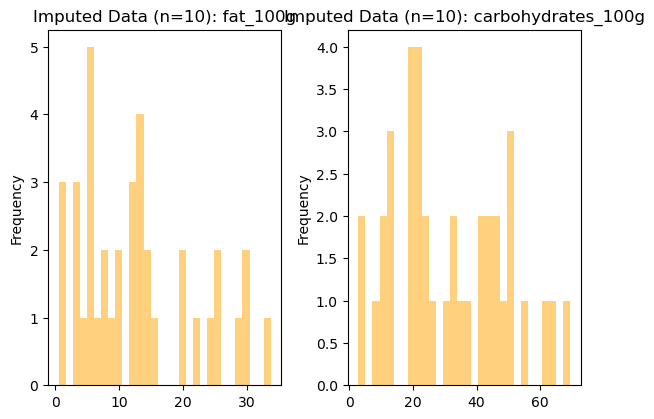

/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/26151

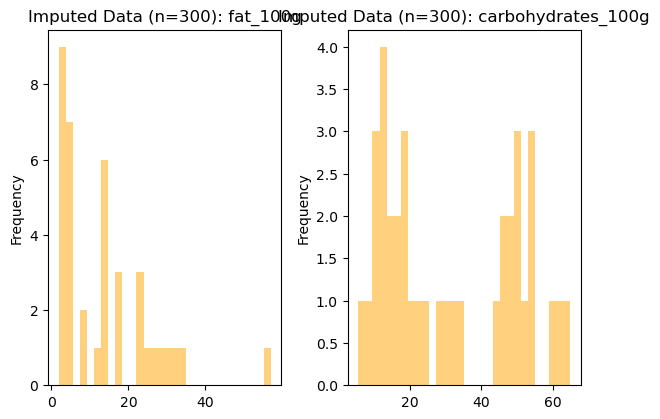

/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/26151

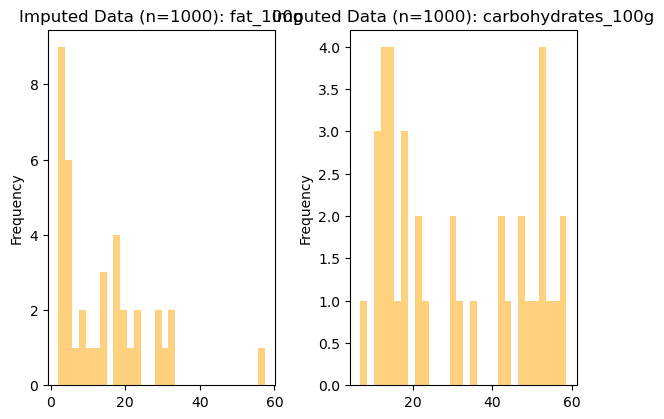

/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/26151

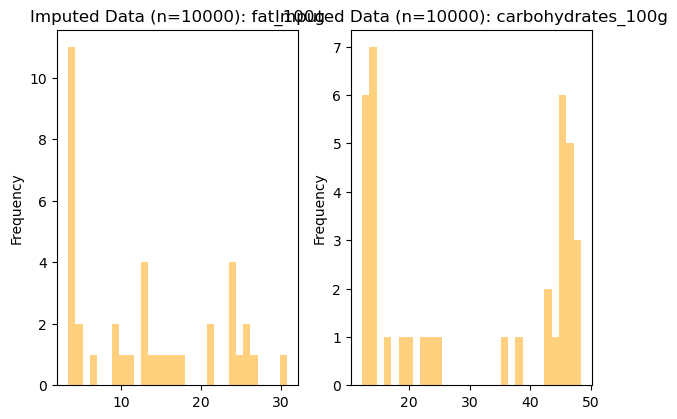

/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/26151

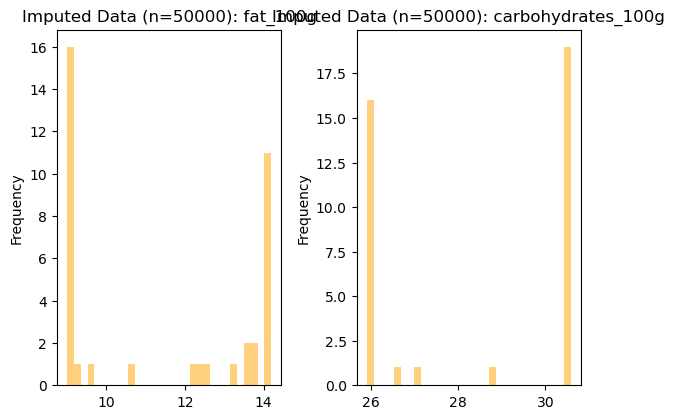

,index,code,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,packaging,ingredients_text,additives,...,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
0,0,36252,Lion Peanut x2,Sunridge,e,unknown,unknown,,"Milk chocolate coating (evaporated cane juice,...",[ milk-chocolate-coating -> en:milk-chocolate...,...,450.047801,20.000000,12.50,70.000000,57.50,2.5,2.50,0.09652,0.038000,22.0
1,1,10187319,Mini Confettis,Alice Délice,d,,,,,,...,418.977055,9.000000,0.80,30.000000,87.70,0.9,0.60,0.01000,0.003937,14.0
2,2,10207260,Praliné Amande Et Noisette,Alice Délice,d,,,,,,...,575.047801,9.000000,2.90,30.000000,50.30,3.9,9.50,0.00300,0.001181,14.0
3,3,40608754,"Pepsi, Nouveau goût !",Pepsi,e,Beverages,Sweetened beverages,Canette aluminium,"Eau gazéifiée, sucre, colorant caramel E150d, ...",[ eau-gazeifiee -> fr:eau-gazeifiee ] [ eau...,...,42.304015,0.000000,0.00,10.400000,10.40,0.0,0.00,0.02540,0.010000,13.0
4,4,69161025,Tarte Poireaux Et Lardons,Bo Frost,d,,,,,,...,257.887189,9.000000,11.00,30.000000,1.00,1.4,7.50,0.80000,0.314961,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59116,59193,9782211109758,Verrine Cheescake Myrtille,Kayser,d,,,,,,...,259.082218,9.590219,12.00,27.137969,10.50,0.0,8.70,0.29000,0.114173,16.0
59117,59194,9782401029101,Fiche Brevet,Hatier,b,,,,,,...,0.956023,9.010456,1.00,25.905169,1.00,10.0,10.00,10.00000,3.937008,0.0
59118,59195,9847548283004,Tartines craquantes bio au sarrasin,Le Pain des fleurs,a,Cereals and potatoes,Bread,"Boîte,Carton,Sachet,Plastique",,,...,392.686424,2.800000,0.60,74.800000,2.60,5.9,13.00,0.68000,0.267717,-4.0
59119,59196,9900000000233,Amandes,Biosic,b,,,,,,...,575.047801,14.187882,3.73,30.530864,3.89,12.2,21.22,0.10000,0.039370,0.0


In [42]:
# Testing KNN imputer with different 'n_neighbors' values :

knn_imputer(2)
knn_imputer(10)
knn_imputer(300)
knn_imputer(1000)
knn_imputer(10000)
knn_imputer(50000)


/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/2615156730.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df_imputed.drop(columns=['index'], inplace=True)
/tmp/ipykernel_7528/26151

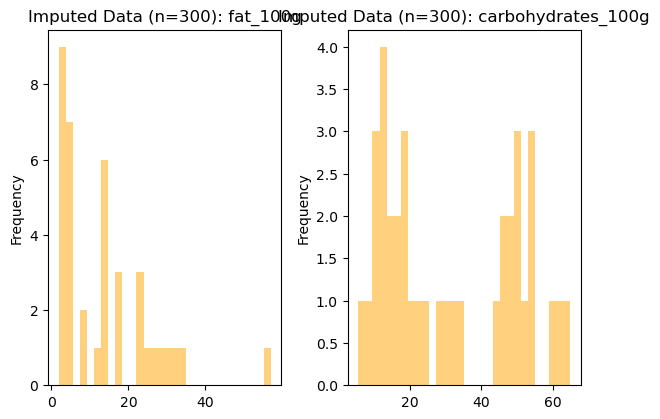

In [43]:
copy_df = knn_imputer(300)

df_final = df_final.merge(copy_df[quant_columns], left_index=True, right_index=True, suffixes=('', '_knn'))

for var in quant_columns:
    df_final[var] = df_final[var].fillna(df_final[f"{var}_knn"])

df_final.drop(columns=[f"{var}_knn" for var in quant_columns], inplace=True)

In [44]:
missing_values(df_final)

Series([], dtype: int64)

### Outliers

In [45]:
df_final = df_final.reset_index(drop=True)
filled_df = filled_df.reset_index(drop=True)

for i,row in df_final.iterrows():
    for variable in ['fat_100g',
                    'saturated-fat_100g',
                    'carbohydrates_100g',
                    'sugars_100g',
                    'fiber_100g',
                    'proteins_100g',
                    'salt_100g',
                    'sodium_100g',
                    'nutrition-score-fr_100g']:
        
        if row[variable] > 100 or row[variable] < 0:
            df_final.loc[i, variable] = filled_df.loc[i, f"{variable}_pnns"]
    
    if row['energy_100g'] > 1500 or row["energy_100g"] < 0:
        df_final.loc[i, "energy_100g"] = filled_df.loc[i, "energy_100g_pnns"]
    
    if row["saturated-fat_100g"] > row["fat_100g"]:
        df_final.loc[i, "saturated-fat_100g"] = min(filled_df.loc[i, "saturated-fat_100g_pnns"], row["fat_100g"])
    
    if row["sugars_100g"] > row["carbohydrates_100g"]:
        df_final.loc[i, "sugars_100g"] = min(filled_df.loc[i, "sugars_100g_pnns"], row["carbohydrates_100g"])
    
    if row['nutrition-score-fr_100g'] > 40 or row['nutrition-score-fr_100g'] < -15:
        df_final.loc[i, 'nutrition-score-fr_100g'] = filled_df.loc[i, 'nutrition-score-fr_100g_pnns']


# Save

In [46]:
df_final.to_csv("data/final_dataset.csv")